# Ensemble learning

## load data

In [1]:
import pandas as pd
import pickle
import os

/home/lichang/.virtualenvs/py38/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# df1 = pd.read_csv(
#     os.path.join("result", "bert-base-cased_bs_8_epo7", "l2", "level2_softmax.csv")
# )
# df2 = pd.read_csv(
#     os.path.join("result", "roberta-base_bs_8_epo10", "l2", "level2_softmax.csv")
# )
# df3 = pd.read_csv(
#     os.path.join("result", "xlnet-base-cased_bs_8_epo10", "l2", "level2_softmax.csv")
# )
# df4 = pd.read_csv(
#     os.path.join(
#         "result",
#         "google_electra-base-discriminator_bs_8_epo10",
#         "l2",
#         "level2_softmax.csv",
#     )
# )
# df5 = pd.read_csv(
#     os.path.join(
#         "result", "microsoft_deberta-base_bs_4_epo9", "l2", "level2_softmax.csv"
#     )
# )

In [3]:
# df1 = pd.read_csv(
#     os.path.join(
#         "result", "bert-base-cased_bs8_lr4e-05_epo10", "l2", "level2_softmax.csv"
#     )
# )
# df2 = pd.read_csv(
#     os.path.join("result", "roberta-base_bs8_lr4e-05_epo10", "l2", "level2_softmax.csv")
# )
# df3 = pd.read_csv(
#     os.path.join("result", "xlnet-base-cased_bs8_lr4e-05_epo10", "l2", "level2_softmax.csv")
# )
# df4 = pd.read_csv(
#     os.path.join(
#         "result",
#         "google_electra-base-discriminator_bs8_lr4e-05_epo10",
#         "l2",
#         "level2_softmax.csv",
#     )
# )
# df5 = pd.read_csv(
#     os.path.join(
#         "result", "microsoft_deberta-base_bs4_lr2e-05_epo10", "l2", "level2_softmax.csv"
#     )
# )

# df6 = pd.read_csv(
#     os.path.join(
#         "result",
#         "textattack_bert-base-uncased-imdb_bs8_lr4e-05_epo10",
#         "l2",
#         "level2_softmax.csv",
#     )
# )

# df7 = pd.read_csv(
#     os.path.join(
#         "result",
#         "aychang_roberta-base-imdb_bs8_lr4e-05_epo10",
#         "l2",
#         "level2_softmax.csv",
#     )
# )

In [4]:
df1 = pd.read_csv(
    os.path.join(
        "result", "bert-base-cased_bs8_lr4e-05_epo2_retrain", "l2", "level2_softmax.csv"
    )
)
df2 = pd.read_csv(
    os.path.join(
        "result", "roberta-base_bs8_lr4e-05_epo3_retrain", "l2", "level2_softmax.csv"
    )
)
df3 = pd.read_csv(
    os.path.join("result", "xlnet-base-cased_bs8_lr4e-05_epo10", "l2", "level2_softmax.csv")
)
df4 = pd.read_csv(
    os.path.join(
        "result",
        "google_electra-base-discriminator_bs8_lr4e-05_epo2_retrain",
        "l2",
        "level2_softmax.csv",
    )
)
df5 = pd.read_csv(
    os.path.join(
        "result",
        "microsoft_deberta-base_bs4_lr2e-05_epo1_retrain",
        "l2",
        "level2_softmax.csv",
    )
)

df6 = pd.read_csv(
    os.path.join(
        "result",
        "textattack_bert-base-uncased-imdb_bs8_lr4e-05_epo1_retrain",
        "l2",
        "level2_softmax.csv",
    )
)

df7 = pd.read_csv(
    os.path.join(
        "result",
        "aychang_roberta-base-imdb_bs8_lr4e-05_epo2_retrain",
        "l2",
        "level2_softmax.csv",
    )
)

In [5]:
# with open(os.path.join("data", "train_valid_split", "level_2", "y_l2.pkl"), "rb") as f:
#     y = pickle.load(f)

with open(
    os.path.join("data", "train_valid_split_without_test", "level_2", "y_l2.pkl"), "rb"
) as f:
    y = pickle.load(f)

In [6]:
X = pd.DataFrame(
    {
        "model_1": df1["sentiment"],
        "model_2": df2["sentiment"],
        "model_3": df3["sentiment"],
        "model_4": df4["sentiment"],
        "model_5": df5["sentiment"],
        "model_6": df6["sentiment"],
        "model_7": df7["sentiment"],
    }
)
X

,model_1,model_2,model_3,model_4,model_5,model_6,model_7
0,0.000993,0.000719,0.005471,0.000370,0.000687,0.001014,0.000992
1,0.999354,0.999354,0.986297,0.999629,0.999730,0.999052,0.999112
2,0.000821,0.000662,0.003949,0.000333,0.000527,0.000787,0.000957
3,0.000807,0.000592,0.004270,0.000332,0.000426,0.000704,0.000946
4,0.006021,0.000666,0.007877,0.000805,0.000845,0.003261,0.001065
...,...,...,...,...,...,...,...
2930,0.000745,0.000590,0.003943,0.000359,0.000422,0.000885,0.000971
2931,0.999338,0.999377,0.988680,0.999629,0.999697,0.999015,0.999117
2932,0.000907,0.000589,0.003934,0.000357,0.000437,0.000708,0.000962
2933,0.964407,0.000701,0.013693,0.001379,0.000479,0.001528,0.001076


## 5-fold

In [8]:
from sklearn.model_selection import StratifiedKFold

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  # init

In [10]:
tr_list_x = []
tr_list_y = []
va_list_x = []
va_list_y = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # train_index
    tr_list_x.append(X.iloc[train_index].values)
    tr_list_y.append(y.iloc[train_index].values)

    # test_index
    va_list_x.append(X.iloc[test_index].values)
    va_list_y.append(y.iloc[test_index].values)

    print(
        "Train Pos: {}, Neg: {}".format(
            sum(y.iloc[train_index] == 0), sum(y.iloc[train_index] == 1)
        )
    )

    print(
        "Valid Pos: {}, Neg: {}".format(
            sum(y.iloc[test_index] == 0), sum(y.iloc[test_index] == 1)
        )
    )

    print("=" * 40)

Train Pos: 1135, Neg: 1213
Valid Pos: 284, Neg: 303
Train Pos: 1135, Neg: 1213
Valid Pos: 284, Neg: 303
Train Pos: 1135, Neg: 1213
Valid Pos: 284, Neg: 303
Train Pos: 1135, Neg: 1213
Valid Pos: 284, Neg: 303
Train Pos: 1136, Neg: 1212
Valid Pos: 283, Neg: 304


## pytorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [12]:
plt.rcParams["figure.figsize"] = (12, 8)

In [13]:
def check_gpu():
    """
    Check if GPU avaliable.
    """
    print()
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(0))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")
    print()

    return device


device = check_gpu()


There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti



In [14]:
class Data(Dataset):
    # Constructor
    def __init__(self, X, y):
        self.x = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.len = self.y.shape[0]

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        return self.len

In [15]:
# create dataset
tr_set = []
va_set = []

for idx in range(len(tr_list_x)):
    tr_set.append(Data(tr_list_x[idx], tr_list_y[idx]))

for idx in range(len(va_list_x)):
    va_set.append(Data(va_list_x[idx], va_list_y[idx]))

In [16]:
class NN(nn.Module):
    # Constructor
    def __init__(self, input_dim, neuron=8, p=0):
        super().__init__()

        self.input_dim = input_dim

        self.neuron = neuron

        self.layer = torch.nn.Sequential(
            # 1
            nn.Linear(self.input_dim, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(p=p),
            # 2
            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(p=p),
            # 3
            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(p=p),
            #
            nn.Linear(self.neuron, 2),
        )

    def forward(self, x):
        x = self.layer(x)
        return x

In [17]:
def batch_iter(
    model, dataloader, optimizer, scheduler, device, criterion, training=True
):

    correct = 0
    training_loss = 0
    TP = FP = TN = FN = 0
    y_list = []
    yhat_list = []

    if training:
        model.train()
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            yhat_prob = F.softmax(z, dim=1)[:, 1]

            # calc metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()

            # calc auc
            y_list.extend(y.cpu().detach().numpy())
            yhat_list.extend(yhat_prob.cpu().detach().numpy())

    else:
        model.eval()
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                z = model(x)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y).sum().item()
                loss = criterion(z, y)
                training_loss += loss.item()
                yhat_prob = F.softmax(z, dim=1)[:, 1]

                # calc metric
                TP += ((yhat == 1) & (y == 1)).sum().item()
                FP += ((yhat == 1) & (y == 0)).sum().item()
                TN += ((yhat == 0) & (y == 0)).sum().item()
                FN += ((yhat == 0) & (y == 1)).sum().item()

                # calc auc
                y_list.extend(y.cpu().detach().numpy())
                yhat_list.extend(yhat_prob.cpu().detach().numpy())

    return model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list

In [18]:
def calc_metrics(
    N_data,
    dataloader,
    correct,
    training_loss,
    confusion_matrix,
    y_list,
    yhat_list,
    useful_stuff,
    mtype,
):
    (TP, FP, TN, FN) = confusion_matrix
    fpr, tpr, _ = metrics.roc_curve(y_list, yhat_list)
    auc = metrics.auc(fpr, tpr)
    acc = correct / N_data
    loss = training_loss / len(dataloader)
    useful_stuff = save_result(
        useful_stuff, acc, loss, (TP, FP, TN, FN), auc, fpr, tpr, mtype
    )

    return useful_stuff

In [19]:
def save_result(useful_stuff, acc, loss, confusion_matrix, auc, fpr, tpr, type):
    (TP, FP, TN, FN) = confusion_matrix
    useful_stuff[type + "_loss"].append(loss)
    useful_stuff[type + "_acc"].append(acc)
    useful_stuff[type + "_metric"].append((TP, FP, TN, FN))
    useful_stuff[type + "_auc"].append(auc)
    useful_stuff[type + "_fpr"].append(fpr)
    useful_stuff[type + "_tpr"].append(tpr)
    return useful_stuff

In [20]:
def train_ensemble(
    model,
    train_loader,
    valid_loader,
    optimizer,
    N_train,
    N_test,
    device,
    criterion,
    scheduler,
    epochs=20,
):

    useful_stuff = {
        "training_loss": [],
        "training_acc": [],
        "training_auc": [],
        "training_metric": [],
        "training_fpr": [],
        "training_tpr": [],
        "train_loss": [],
        "train_acc": [],
        "train_auc": [],
        "train_metric": [],
        "train_fpr": [],
        "train_tpr": [],
        "valid_loss": [],
        "valid_acc": [],
        "valid_auc": [],
        "valid_metric": [],
        "valid_fpr": [],
        "valid_tpr": [],
    }

    for epoch in range(epochs):

        # training
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, train_loader, optimizer, scheduler, device, criterion, training=True
        )

        useful_stuff = calc_metrics(
            N_train,
            train_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="training",
        )

        # evaluate training
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, train_loader, optimizer, scheduler, device, criterion, training=False
        )

        useful_stuff = calc_metrics(
            N_train,
            train_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="train",
        )

        # Validation
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, valid_loader, optimizer, scheduler, device, criterion, training=False
        )

        useful_stuff = calc_metrics(
            N_test,
            valid_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="valid",
        )

        scheduler.step(training_loss)
        print(
            "[Epo {:2}] tr_acc: {:.2f} tr_oss: {:.2f} va_acc: {:.2f} va_loss: {:.2f}".format(
                epoch,
                useful_stuff["train_acc"][-1],
                useful_stuff["train_loss"][-1],
                useful_stuff["valid_acc"][-1],
                useful_stuff["valid_loss"][-1],
            )
        )

    return useful_stuff

In [21]:
# hypterparameter
epochs = 60
batch_size = 32
lr = 2e-4
dropout_rate = 0.1
neuron = 10
print("epochs:", epochs)
print("batch_size:", batch_size)
print("learning rate:", lr)
print("dropout_rate:", dropout_rate)
print("neurons per layer:", neuron)

epochs: 60
batch_size: 32
learning rate: 0.0002
dropout_rate: 0.1
neurons per layer: 10


In [23]:
# training
training_hist = []
for fold in range(5):

    model = NN(input_dim=7, neuron=neuron, p=dropout_rate)
    model.to(device)

    N_train = len(tr_set[fold])
    N_test = len(va_set[fold])
    print("[Fold]:", fold)
    print("Num of train samples:", N_train)
    print("Num of valid samples:", N_test)
    print()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
    )

    criterion = nn.CrossEntropyLoss()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=10, factor=0.5, verbose=True
    )

    tr_loader = DataLoader(tr_set[fold], shuffle=True, batch_size=batch_size)

    va_loader = DataLoader(va_set[fold], shuffle=False, batch_size=batch_size * 8)

    useful_stuff = train_ensemble(
        model=model,
        train_loader=tr_loader,
        valid_loader=va_loader,
        optimizer=optimizer,
        N_train=N_train,
        N_test=N_test,
        device=device,
        criterion=criterion,
        scheduler=scheduler,
        epochs=epochs,
    )

    training_hist.append(useful_stuff)
    print("*" * 50)
    print("*" * 50)
    print("*" * 50)

[Fold]: 0
Num of train samples: 2348
Num of valid samples: 587

[Epo  0] tr_acc: 0.93 tr_oss: 0.61 va_acc: 0.93 va_loss: 0.60
[Epo  1] tr_acc: 0.93 tr_oss: 0.57 va_acc: 0.92 va_loss: 0.57
[Epo  2] tr_acc: 0.94 tr_oss: 0.52 va_acc: 0.94 va_loss: 0.52
[Epo  3] tr_acc: 0.94 tr_oss: 0.48 va_acc: 0.94 va_loss: 0.48
[Epo  4] tr_acc: 0.94 tr_oss: 0.46 va_acc: 0.94 va_loss: 0.46
[Epo  5] tr_acc: 0.94 tr_oss: 0.42 va_acc: 0.94 va_loss: 0.42
[Epo  6] tr_acc: 0.94 tr_oss: 0.39 va_acc: 0.94 va_loss: 0.40
[Epo  7] tr_acc: 0.94 tr_oss: 0.36 va_acc: 0.94 va_loss: 0.37
[Epo  8] tr_acc: 0.94 tr_oss: 0.34 va_acc: 0.94 va_loss: 0.35
[Epo  9] tr_acc: 0.94 tr_oss: 0.32 va_acc: 0.94 va_loss: 0.33
[Epo 10] tr_acc: 0.95 tr_oss: 0.29 va_acc: 0.95 va_loss: 0.30
[Epo 11] tr_acc: 0.95 tr_oss: 0.27 va_acc: 0.95 va_loss: 0.28
[Epo 12] tr_acc: 0.95 tr_oss: 0.25 va_acc: 0.95 va_loss: 0.26
[Epo 13] tr_acc: 0.95 tr_oss: 0.24 va_acc: 0.95 va_loss: 0.25
[Epo 14] tr_acc: 0.95 tr_oss: 0.23 va_acc: 0.95 va_loss: 0.23
[Epo 1

[Epo  2] tr_acc: 0.94 tr_oss: 0.53 va_acc: 0.94 va_loss: 0.52
[Epo  3] tr_acc: 0.94 tr_oss: 0.46 va_acc: 0.94 va_loss: 0.45
[Epo  4] tr_acc: 0.94 tr_oss: 0.41 va_acc: 0.94 va_loss: 0.40
[Epo  5] tr_acc: 0.94 tr_oss: 0.38 va_acc: 0.95 va_loss: 0.37
[Epo  6] tr_acc: 0.95 tr_oss: 0.34 va_acc: 0.95 va_loss: 0.34
[Epo  7] tr_acc: 0.95 tr_oss: 0.32 va_acc: 0.95 va_loss: 0.31
[Epo  8] tr_acc: 0.94 tr_oss: 0.28 va_acc: 0.95 va_loss: 0.27
[Epo  9] tr_acc: 0.95 tr_oss: 0.28 va_acc: 0.96 va_loss: 0.27
[Epo 10] tr_acc: 0.95 tr_oss: 0.27 va_acc: 0.95 va_loss: 0.26
[Epo 11] tr_acc: 0.95 tr_oss: 0.25 va_acc: 0.96 va_loss: 0.24
[Epo 12] tr_acc: 0.95 tr_oss: 0.24 va_acc: 0.95 va_loss: 0.23
[Epo 13] tr_acc: 0.95 tr_oss: 0.24 va_acc: 0.96 va_loss: 0.22
[Epo 14] tr_acc: 0.95 tr_oss: 0.23 va_acc: 0.96 va_loss: 0.21
[Epo 15] tr_acc: 0.95 tr_oss: 0.22 va_acc: 0.96 va_loss: 0.21
[Epo 16] tr_acc: 0.95 tr_oss: 0.21 va_acc: 0.96 va_loss: 0.20
[Epo 17] tr_acc: 0.95 tr_oss: 0.21 va_acc: 0.96 va_loss: 0.20
[Epo 18]

[Epo  8] tr_acc: 0.94 tr_oss: 0.30 va_acc: 0.95 va_loss: 0.30
[Epo  9] tr_acc: 0.94 tr_oss: 0.27 va_acc: 0.94 va_loss: 0.28
[Epo 10] tr_acc: 0.94 tr_oss: 0.26 va_acc: 0.94 va_loss: 0.26
[Epo 11] tr_acc: 0.94 tr_oss: 0.24 va_acc: 0.95 va_loss: 0.24
[Epo 12] tr_acc: 0.94 tr_oss: 0.23 va_acc: 0.94 va_loss: 0.23
[Epo 13] tr_acc: 0.94 tr_oss: 0.21 va_acc: 0.94 va_loss: 0.21
[Epo 14] tr_acc: 0.95 tr_oss: 0.21 va_acc: 0.95 va_loss: 0.22
[Epo 15] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.95 va_loss: 0.21
[Epo 16] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.94 va_loss: 0.20
[Epo 17] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.94 va_loss: 0.19
[Epo 18] tr_acc: 0.95 tr_oss: 0.19 va_acc: 0.95 va_loss: 0.19
[Epo 19] tr_acc: 0.95 tr_oss: 0.19 va_acc: 0.95 va_loss: 0.18
[Epo 20] tr_acc: 0.95 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.18
[Epo 21] tr_acc: 0.95 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.19
[Epo 22] tr_acc: 0.95 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.17
[Epo 23] tr_acc: 0.95 tr_oss: 0.17 va_acc: 0.95 va_loss: 0.17
[Epo 24]

In [45]:
# training
training_hist = []
for fold in range(5):

    model = NN(input_dim=7, neuron=neuron, p=dropout_rate)
    model.to(device)

    N_train = len(tr_set[fold])
    N_test = len(va_set[fold])
    print("[Fold]:", fold)
    print("Num of train samples:", N_train)
    print("Num of valid samples:", N_test)
    print()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
    )

    criterion = nn.CrossEntropyLoss()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=10, factor=0.5, verbose=True
    )

    tr_loader = DataLoader(tr_set[fold], shuffle=True, batch_size=batch_size)

    va_loader = DataLoader(va_set[fold], shuffle=False, batch_size=batch_size * 8)

    useful_stuff = train_ensemble(
        model=model,
        train_loader=tr_loader,
        valid_loader=va_loader,
        optimizer=optimizer,
        N_train=N_train,
        N_test=N_test,
        device=device,
        criterion=criterion,
        scheduler=scheduler,
        epochs=epochs,
    )

    training_hist.append(useful_stuff)
    print("*" * 50)
    print("*" * 50)
    print("*" * 50)

[Fold]: 0
Num of train samples: 2348
Num of valid samples: 587

[Epo  0] tr_acc: 0.90 tr_oss: 0.59 va_acc: 0.89 va_loss: 0.60
[Epo  1] tr_acc: 0.92 tr_oss: 0.55 va_acc: 0.90 va_loss: 0.55
[Epo  2] tr_acc: 0.93 tr_oss: 0.50 va_acc: 0.91 va_loss: 0.50
[Epo  3] tr_acc: 0.93 tr_oss: 0.45 va_acc: 0.92 va_loss: 0.45
[Epo  4] tr_acc: 0.93 tr_oss: 0.40 va_acc: 0.93 va_loss: 0.40
[Epo  5] tr_acc: 0.94 tr_oss: 0.36 va_acc: 0.93 va_loss: 0.36
[Epo  6] tr_acc: 0.94 tr_oss: 0.33 va_acc: 0.93 va_loss: 0.32
[Epo  7] tr_acc: 0.94 tr_oss: 0.31 va_acc: 0.94 va_loss: 0.30
[Epo  8] tr_acc: 0.94 tr_oss: 0.28 va_acc: 0.94 va_loss: 0.28
[Epo  9] tr_acc: 0.94 tr_oss: 0.26 va_acc: 0.94 va_loss: 0.26
[Epo 10] tr_acc: 0.94 tr_oss: 0.25 va_acc: 0.94 va_loss: 0.25
[Epo 11] tr_acc: 0.94 tr_oss: 0.23 va_acc: 0.94 va_loss: 0.23
[Epo 12] tr_acc: 0.94 tr_oss: 0.22 va_acc: 0.94 va_loss: 0.22
[Epo 13] tr_acc: 0.95 tr_oss: 0.21 va_acc: 0.94 va_loss: 0.21
[Epo 14] tr_acc: 0.95 tr_oss: 0.20 va_acc: 0.94 va_loss: 0.20
[Epo 1

[Epo  5] tr_acc: 0.92 tr_oss: 0.27 va_acc: 0.94 va_loss: 0.24
[Epo  6] tr_acc: 0.93 tr_oss: 0.25 va_acc: 0.94 va_loss: 0.22
[Epo  7] tr_acc: 0.93 tr_oss: 0.24 va_acc: 0.94 va_loss: 0.21
[Epo  8] tr_acc: 0.93 tr_oss: 0.23 va_acc: 0.94 va_loss: 0.21
[Epo  9] tr_acc: 0.94 tr_oss: 0.23 va_acc: 0.94 va_loss: 0.20
[Epo 10] tr_acc: 0.94 tr_oss: 0.21 va_acc: 0.94 va_loss: 0.19
[Epo 11] tr_acc: 0.94 tr_oss: 0.21 va_acc: 0.94 va_loss: 0.18
[Epo 12] tr_acc: 0.94 tr_oss: 0.21 va_acc: 0.94 va_loss: 0.18
[Epo 13] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.94 va_loss: 0.17
[Epo 14] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.94 va_loss: 0.17
[Epo 15] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.94 va_loss: 0.17
[Epo 16] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.94 va_loss: 0.16
[Epo 17] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.16
[Epo 18] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.94 va_loss: 0.16
[Epo 19] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.94 va_loss: 0.16
[Epo 20] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.94 va_loss: 0.15
[Epo 21]

[Epo  9] tr_acc: 0.93 tr_oss: 0.26 va_acc: 0.93 va_loss: 0.26
[Epo 10] tr_acc: 0.93 tr_oss: 0.24 va_acc: 0.93 va_loss: 0.25
[Epo 11] tr_acc: 0.93 tr_oss: 0.23 va_acc: 0.93 va_loss: 0.24
[Epo 12] tr_acc: 0.93 tr_oss: 0.22 va_acc: 0.93 va_loss: 0.23
[Epo 13] tr_acc: 0.93 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.22
[Epo 14] tr_acc: 0.93 tr_oss: 0.20 va_acc: 0.93 va_loss: 0.21
[Epo 15] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.93 va_loss: 0.20
[Epo 16] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.93 va_loss: 0.20
[Epo 17] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.93 va_loss: 0.20
[Epo 18] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.94 va_loss: 0.20
[Epo 19] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.93 va_loss: 0.19
[Epo 20] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.93 va_loss: 0.19
[Epo 21] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.94 va_loss: 0.18
[Epo 22] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.94 va_loss: 0.18
[Epo 23] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.94 va_loss: 0.18
[Epo 24] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.94 va_loss: 0.18
[Epo 25]

In [24]:
# training
training_hist = []
for fold in range(5):

    model = NN(input_dim=7, neuron=neuron, p=dropout_rate)
    model.to(device)

    N_train = len(tr_set[fold])
    N_test = len(va_set[fold])
    print("[Fold]:", fold)
    print("Num of train samples:", N_train)
    print("Num of valid samples:", N_test)
    print()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
    )

    criterion = nn.CrossEntropyLoss()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=10, factor=0.5, verbose=True
    )

    tr_loader = DataLoader(tr_set[fold], shuffle=True, batch_size=batch_size)

    va_loader = DataLoader(va_set[fold], shuffle=False, batch_size=batch_size * 8)

    useful_stuff = train_ensemble(
        model=model,
        train_loader=tr_loader,
        valid_loader=va_loader,
        optimizer=optimizer,
        N_train=N_train,
        N_test=N_test,
        device=device,
        criterion=criterion,
        scheduler=scheduler,
        epochs=epochs,
    )

    training_hist.append(useful_stuff)
    print("*" * 50)
    print("*" * 50)
    print("*" * 50)

[Fold]: 0
Num of train samples: 2348
Num of valid samples: 587

[Epo  0] tr_acc: 0.91 tr_oss: 0.62 va_acc: 0.90 va_loss: 0.61
[Epo  1] tr_acc: 0.93 tr_oss: 0.52 va_acc: 0.91 va_loss: 0.52
[Epo  2] tr_acc: 0.93 tr_oss: 0.44 va_acc: 0.92 va_loss: 0.45
[Epo  3] tr_acc: 0.93 tr_oss: 0.41 va_acc: 0.92 va_loss: 0.42
[Epo  4] tr_acc: 0.93 tr_oss: 0.36 va_acc: 0.92 va_loss: 0.37
[Epo  5] tr_acc: 0.93 tr_oss: 0.32 va_acc: 0.92 va_loss: 0.34
[Epo  6] tr_acc: 0.93 tr_oss: 0.29 va_acc: 0.93 va_loss: 0.31
[Epo  7] tr_acc: 0.93 tr_oss: 0.27 va_acc: 0.93 va_loss: 0.29
[Epo  8] tr_acc: 0.93 tr_oss: 0.25 va_acc: 0.93 va_loss: 0.27
[Epo  9] tr_acc: 0.94 tr_oss: 0.24 va_acc: 0.93 va_loss: 0.26
[Epo 10] tr_acc: 0.94 tr_oss: 0.23 va_acc: 0.93 va_loss: 0.25
[Epo 11] tr_acc: 0.94 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.24
[Epo 12] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.93 va_loss: 0.23
[Epo 13] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.93 va_loss: 0.23
[Epo 14] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.93 va_loss: 0.22
[Epo 1

[Epo  4] tr_acc: 0.94 tr_oss: 0.43 va_acc: 0.94 va_loss: 0.42
[Epo  5] tr_acc: 0.94 tr_oss: 0.39 va_acc: 0.94 va_loss: 0.38
[Epo  6] tr_acc: 0.94 tr_oss: 0.35 va_acc: 0.94 va_loss: 0.34
[Epo  7] tr_acc: 0.94 tr_oss: 0.31 va_acc: 0.95 va_loss: 0.30
[Epo  8] tr_acc: 0.95 tr_oss: 0.29 va_acc: 0.95 va_loss: 0.27
[Epo  9] tr_acc: 0.94 tr_oss: 0.27 va_acc: 0.95 va_loss: 0.25
[Epo 10] tr_acc: 0.95 tr_oss: 0.25 va_acc: 0.95 va_loss: 0.23
[Epo 11] tr_acc: 0.95 tr_oss: 0.23 va_acc: 0.95 va_loss: 0.22
[Epo 12] tr_acc: 0.95 tr_oss: 0.22 va_acc: 0.95 va_loss: 0.21
[Epo 13] tr_acc: 0.95 tr_oss: 0.21 va_acc: 0.95 va_loss: 0.19
[Epo 14] tr_acc: 0.95 tr_oss: 0.20 va_acc: 0.95 va_loss: 0.19
[Epo 15] tr_acc: 0.95 tr_oss: 0.20 va_acc: 0.95 va_loss: 0.18
[Epo 16] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.95 va_loss: 0.18
[Epo 17] tr_acc: 0.95 tr_oss: 0.19 va_acc: 0.95 va_loss: 0.17
[Epo 18] tr_acc: 0.95 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.16
[Epo 19] tr_acc: 0.95 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.16
[Epo 20]

[Epo 10] tr_acc: 0.94 tr_oss: 0.22 va_acc: 0.94 va_loss: 0.22
[Epo 11] tr_acc: 0.94 tr_oss: 0.22 va_acc: 0.94 va_loss: 0.22
[Epo 12] tr_acc: 0.94 tr_oss: 0.21 va_acc: 0.94 va_loss: 0.21
[Epo 13] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.94 va_loss: 0.20
[Epo 14] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.94 va_loss: 0.20
[Epo 15] tr_acc: 0.94 tr_oss: 0.19 va_acc: 0.95 va_loss: 0.19
[Epo 16] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.19
[Epo 17] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.18
[Epo 18] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.18
[Epo 19] tr_acc: 0.94 tr_oss: 0.18 va_acc: 0.95 va_loss: 0.18
[Epo 20] tr_acc: 0.94 tr_oss: 0.17 va_acc: 0.95 va_loss: 0.18
[Epo 21] tr_acc: 0.94 tr_oss: 0.17 va_acc: 0.95 va_loss: 0.17
[Epo 22] tr_acc: 0.94 tr_oss: 0.17 va_acc: 0.95 va_loss: 0.17
[Epo 23] tr_acc: 0.95 tr_oss: 0.17 va_acc: 0.95 va_loss: 0.18
[Epo 24] tr_acc: 0.95 tr_oss: 0.17 va_acc: 0.95 va_loss: 0.17
[Epo 25] tr_acc: 0.95 tr_oss: 0.17 va_acc: 0.95 va_loss: 0.17
[Epo 26]

In [121]:
# training
training_hist = []
for fold in range(5):

    model = NN(input_dim=5, neuron=neuron, p=dropout_rate)
    model.to(device)

    N_train = len(tr_set[fold])
    N_test = len(va_set[fold])
    print("[Fold]:", fold)
    print("Num of train samples:", N_train)
    print("Num of valid samples:", N_test)
    print()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
    )

    criterion = nn.CrossEntropyLoss()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=10, factor=0.5, verbose=True
    )

    tr_loader = DataLoader(tr_set[fold], shuffle=True, batch_size=batch_size)

    va_loader = DataLoader(va_set[fold], shuffle=False, batch_size=batch_size * 8)

    useful_stuff = train_ensemble(
        model=model,
        train_loader=tr_loader,
        valid_loader=va_loader,
        optimizer=optimizer,
        N_train=N_train,
        N_test=N_test,
        device=device,
        criterion=criterion,
        scheduler=scheduler,
        epochs=epochs,
    )

    training_hist.append(useful_stuff)
    print("*" * 50)
    print("*" * 50)
    print("*" * 50)

[Fold]: 0
Num of train samples: 1878
Num of valid samples: 470

[Epo  0] tr_acc: 0.52 tr_oss: 0.64 va_acc: 0.53 va_loss: 0.63
[Epo  1] tr_acc: 0.52 tr_oss: 0.57 va_acc: 0.53 va_loss: 0.56
[Epo  2] tr_acc: 0.90 tr_oss: 0.49 va_acc: 0.91 va_loss: 0.48
[Epo  3] tr_acc: 0.90 tr_oss: 0.45 va_acc: 0.91 va_loss: 0.44
[Epo  4] tr_acc: 0.91 tr_oss: 0.43 va_acc: 0.91 va_loss: 0.41
[Epo  5] tr_acc: 0.92 tr_oss: 0.39 va_acc: 0.92 va_loss: 0.38
[Epo  6] tr_acc: 0.92 tr_oss: 0.36 va_acc: 0.93 va_loss: 0.36
[Epo  7] tr_acc: 0.92 tr_oss: 0.34 va_acc: 0.93 va_loss: 0.34
[Epo  8] tr_acc: 0.92 tr_oss: 0.32 va_acc: 0.93 va_loss: 0.31
[Epo  9] tr_acc: 0.93 tr_oss: 0.30 va_acc: 0.94 va_loss: 0.30
[Epo 10] tr_acc: 0.93 tr_oss: 0.29 va_acc: 0.94 va_loss: 0.28
[Epo 11] tr_acc: 0.93 tr_oss: 0.27 va_acc: 0.94 va_loss: 0.27
[Epo 12] tr_acc: 0.94 tr_oss: 0.26 va_acc: 0.94 va_loss: 0.26
[Epo 13] tr_acc: 0.94 tr_oss: 0.25 va_acc: 0.94 va_loss: 0.25
[Epo 14] tr_acc: 0.93 tr_oss: 0.24 va_acc: 0.94 va_loss: 0.24
[Epo 1

[Epo  4] tr_acc: 0.92 tr_oss: 0.43 va_acc: 0.90 va_loss: 0.44
[Epo  5] tr_acc: 0.92 tr_oss: 0.40 va_acc: 0.90 va_loss: 0.42
[Epo  6] tr_acc: 0.92 tr_oss: 0.37 va_acc: 0.91 va_loss: 0.39
[Epo  7] tr_acc: 0.93 tr_oss: 0.35 va_acc: 0.91 va_loss: 0.36
[Epo  8] tr_acc: 0.93 tr_oss: 0.33 va_acc: 0.91 va_loss: 0.35
[Epo  9] tr_acc: 0.93 tr_oss: 0.30 va_acc: 0.91 va_loss: 0.33
[Epo 10] tr_acc: 0.93 tr_oss: 0.29 va_acc: 0.92 va_loss: 0.32
[Epo 11] tr_acc: 0.93 tr_oss: 0.28 va_acc: 0.92 va_loss: 0.30
[Epo 12] tr_acc: 0.93 tr_oss: 0.27 va_acc: 0.91 va_loss: 0.29
[Epo 13] tr_acc: 0.93 tr_oss: 0.26 va_acc: 0.92 va_loss: 0.28
[Epo 14] tr_acc: 0.93 tr_oss: 0.25 va_acc: 0.91 va_loss: 0.27
[Epo 15] tr_acc: 0.93 tr_oss: 0.24 va_acc: 0.91 va_loss: 0.27
[Epo 16] tr_acc: 0.93 tr_oss: 0.23 va_acc: 0.91 va_loss: 0.26
[Epo 17] tr_acc: 0.93 tr_oss: 0.23 va_acc: 0.91 va_loss: 0.25
[Epo 18] tr_acc: 0.93 tr_oss: 0.22 va_acc: 0.92 va_loss: 0.25
[Epo 19] tr_acc: 0.93 tr_oss: 0.22 va_acc: 0.92 va_loss: 0.25
[Epo 20]

[Epo  7] tr_acc: 0.93 tr_oss: 0.29 va_acc: 0.92 va_loss: 0.30
[Epo  8] tr_acc: 0.93 tr_oss: 0.28 va_acc: 0.92 va_loss: 0.29
[Epo  9] tr_acc: 0.93 tr_oss: 0.27 va_acc: 0.92 va_loss: 0.27
[Epo 10] tr_acc: 0.93 tr_oss: 0.26 va_acc: 0.92 va_loss: 0.26
[Epo 11] tr_acc: 0.93 tr_oss: 0.25 va_acc: 0.92 va_loss: 0.25
[Epo 12] tr_acc: 0.93 tr_oss: 0.24 va_acc: 0.92 va_loss: 0.24
[Epo 13] tr_acc: 0.93 tr_oss: 0.23 va_acc: 0.92 va_loss: 0.23
[Epo 14] tr_acc: 0.93 tr_oss: 0.22 va_acc: 0.93 va_loss: 0.22
[Epo 15] tr_acc: 0.93 tr_oss: 0.22 va_acc: 0.93 va_loss: 0.22
[Epo 16] tr_acc: 0.94 tr_oss: 0.22 va_acc: 0.92 va_loss: 0.22
[Epo 17] tr_acc: 0.93 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.21
[Epo 18] tr_acc: 0.93 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.21
[Epo 19] tr_acc: 0.93 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.21
[Epo 20] tr_acc: 0.94 tr_oss: 0.21 va_acc: 0.93 va_loss: 0.20
[Epo 21] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.93 va_loss: 0.20
[Epo 22] tr_acc: 0.94 tr_oss: 0.20 va_acc: 0.93 va_loss: 0.20
[Epo 23]

## Metrics

In [24]:
def calc_metric_ensemble(history, train_metric=True, detail=False):
    """
    Calculate metric.
    """
    # init
    ACC = []
    LOSS = []
    RECALL = []
    SPECIFICITY = []
    PRECISION = []
    NPV = []
    F1 = []
    MCC = []
    AUC = []
    FPR = []
    TPR = []

    for i in range(len(history)):

        if train_metric:
            (TP, FP, TN, FN) = history[i]["train_metric"][-1]
            auc = history[i]["train_auc"][-1]
            fpr = history[i]["train_fpr"][-1]
            tpr = history[i]["train_tpr"][-1]
            loss = history[i]["train_loss"][-1]
        else:
            (TP, FP, TN, FN) = history[i]["valid_metric"][-1]
            auc = history[i]["valid_auc"][-1]
            fpr = history[i]["valid_fpr"][-1]
            tpr = history[i]["valid_tpr"][-1]
            loss = history[i]["valid_loss"][-1]

        acc = (TP + TN) / (TP + FP + TN + FN)

        try:
            recall = TP / (TP + FN)  # 召回率是在所有正樣本當中，能夠預測多少正樣本的比例
        except:
            recall = 0

        try:
            specificity = TN / (TN + FP)  # 特異度是在所有負樣本當中，能夠預測多少負樣本的比例
        except:
            specificity = 0

        try:
            precision = TP / (TP + FP)  # 準確率為在所有預測為正樣本中，有多少為正樣本
        except:
            precision = 0

        try:
            npv = TN / (TN + FN)  # npv為在所有預測為正樣本中，有多少為正樣本
        except:
            npv = 0

        try:
            f1 = (2 * recall * precision) / (recall + precision)  # F1-score則是兩者的調和平均數
        except:
            f1 = 0

        try:
            mcc = (TP * TN - FP * FN) / np.sqrt(
                ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
            )
        except:
            mcc = 0

        if detail:
            print("[ fold", i, "]", "(Total sample: {})".format(TP + FP + TN + FN))
            print("TP:", TP)
            print("FP:", FP)
            print("TN:", TN)
            print("FN:", FN)
            print()
            print("acc:", acc)
            print("loss:", loss)
            print("recall:", recall)
            print("specificity:", specificity)
            print("precision:", precision)
            print("npv:", npv)
            print("f1:", f1)
            print("mcc:", mcc)
            print("auc:", auc)
            print("fpr:", fpr)
            print("tpr:", tpr)
            print("=" * 40)

        ACC.append(acc)
        LOSS.append(loss)
        RECALL.append(recall)
        SPECIFICITY.append(specificity)
        PRECISION.append(precision)
        NPV.append(npv)
        F1.append(f1)
        MCC.append(mcc)
        AUC.append(auc)
        FPR.append(fpr)
        TPR.append(tpr)

    if train_metric:
        print("\n[Training average]\n")
    else:
        print("\n[valid average]\n")
    print("ACC: {:.2}".format((np.mean(ACC))))
    print("LOSS: {:.2}".format(np.mean(LOSS)))
    print()
    print("Recall: {:.2}".format(np.mean(RECALL)))
    print("Specificity: {:.2}".format(np.mean(SPECIFICITY)))
    print("Precision: {:.2}".format(np.mean(PRECISION)))
    print("NPV: {:.2}".format(np.mean(NPV)))
    print()
    print("F1: {:.2}".format(np.mean(F1)))
    print("MCC: {:.2}".format(np.mean(MCC)))
    print("AUC: {:.12}".format(np.mean(AUC)))
    print()

In [25]:
calc_metric_ensemble(training_hist, train_metric=True, detail=False)
calc_metric_ensemble(training_hist, train_metric=False, detail=False)


[Training average]

ACC: 0.96
LOSS: 0.15

Recall: 0.96
Specificity: 0.95
Precision: 0.95
NPV: 0.96

F1: 0.96
MCC: 0.91
AUC: 0.985166194206


[valid average]

ACC: 0.95
LOSS: 0.16

Recall: 0.95
Specificity: 0.95
Precision: 0.95
NPV: 0.95

F1: 0.95
MCC: 0.9
AUC: 0.981541846244



In [46]:
calc_metric_ensemble(training_hist, train_metric=True, detail=False)
calc_metric_ensemble(training_hist, train_metric=False, detail=False)


[Training average]

ACC: 0.95
LOSS: 0.16

Recall: 0.95
Specificity: 0.95
Precision: 0.95
NPV: 0.95

F1: 0.95
MCC: 0.9
AUC: 0.98


[valid average]

ACC: 0.95
LOSS: 0.17

Recall: 0.95
Specificity: 0.94
Precision: 0.94
NPV: 0.95

F1: 0.95
MCC: 0.89
AUC: 0.98



## Learning curve

In [26]:
def plot_roc(history, mtype="train"):
    """
    plot roc curve and save as png
    """
    for i in range(len(history)):
        auc = history[i][mtype + "_auc"][-1]
        fpr = history[i][mtype + "_fpr"][-1]
        tpr = history[i][mtype + "_tpr"][-1]

        plt.plot(fpr, tpr, label="Fold-" + str(i) + " AUC = %0.2f" % auc)

    plt.title(mtype + " roc curve")
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    #     plt.savefig(fig_path + mtype + "-roc" + ".png", bbox_inches="tight")
    #     plt.close()
    plt.show()

In [27]:
def calc_avg(history):
    """
    Plot learning curve
    """

    a1 = a2 = a3 = a4 = []  # init

    for i in range(len(history)):
        if i == 0:
            a1 = np.array(history[0]["train_loss"].copy())
            a2 = np.array(history[0]["valid_loss"].copy())
            a3 = np.array(history[0]["train_acc"].copy())
            a4 = np.array(history[0]["valid_acc"].copy())
            continue
        a1 = a1 + np.array(history[i]["train_loss"])
        a2 = a2 + np.array(history[i]["valid_loss"])
        a3 = a3 + np.array(history[i]["train_acc"])
        a4 = a4 + np.array(history[i]["valid_acc"])

    a1 /= len(history)
    a2 /= len(history)
    a3 /= len(history)
    a4 /= len(history)

    a1 = a1.tolist()
    a2 = a2.tolist()
    a3 = a3.tolist()
    a4 = a4.tolist()

    return a1, a2, a3, a4

In [28]:
def plot_lc_ensemble(history):

    a1, a2, a3, a4 = calc_avg(history)

    # color
    tr_color = ["#2ff5f2", "#2ff5e8", "#2ff5c0", "#2fbdf5", "#2f99f5"]
    val_color = ["#f5952f", "#f5ac2f", "#f5c02f", "#f5d72f", "#f5ee2f"]

    # train loss
    for idx, color in enumerate(tr_color):
        plt.plot(
            history[idx]["train_loss"],
            "--",
            alpha=0.4,
            label="train" + str(idx),
            color=color,
        )
    plt.plot(a1, label="average training")

    # valid loss
    for idx, color in enumerate(val_color):
        plt.plot(
            history[idx]["valid_loss"],
            "--",
            alpha=0.4,
            label="valid" + str(idx),
            color=color,
        )

    plt.plot(a2, label="average valid")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.legend()
    plt.title("training / valid loss vs iterations")
    plt.grid()
    #     plt.savefig(fig_path + "loss" + ".png", bbox_inches="tight")
    #     plt.close()
    plt.show()

    # train acc
    for idx, color in enumerate(tr_color):
        plt.plot(
            history[idx]["train_acc"],
            "--",
            alpha=0.4,
            label="train" + str(idx),
            color=color,
        )
    plt.plot(a3, label="average training")

    # valid acc
    for idx, color in enumerate(val_color):
        plt.plot(
            history[idx]["valid_acc"],
            "--",
            alpha=0.4,
            label="valid" + str(idx),
            color=color,
        )
    plt.plot(a4, label="average valid")
    plt.ylabel("acc")
    plt.xlabel("epochs")
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    plt.legend()
    plt.title("training / valid acc vs iterations")
    plt.grid()
    plt.show()
    # plt.savefig(fig_path + "acc" + ".png", bbox_inches="tight")
    # plt.close()

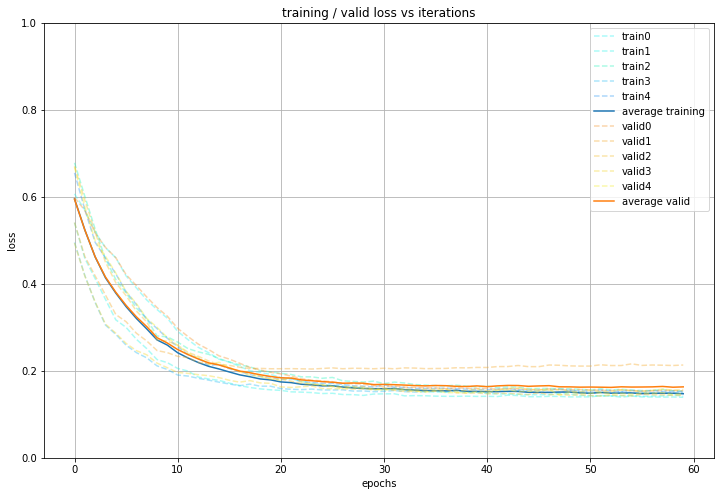

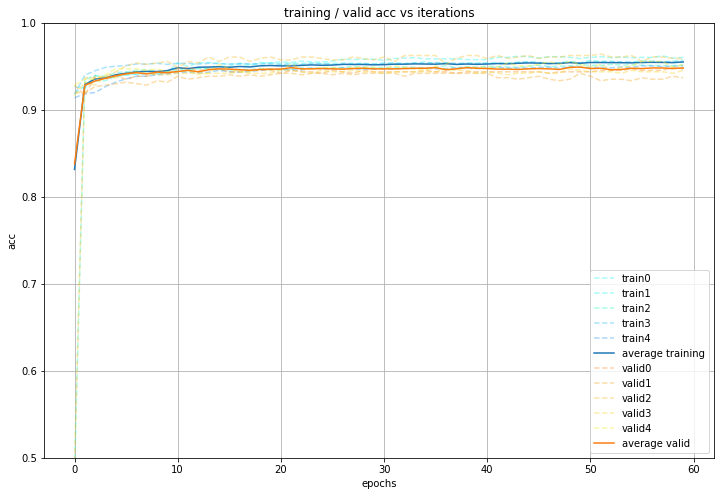

In [29]:
plot_lc_ensemble(training_hist)

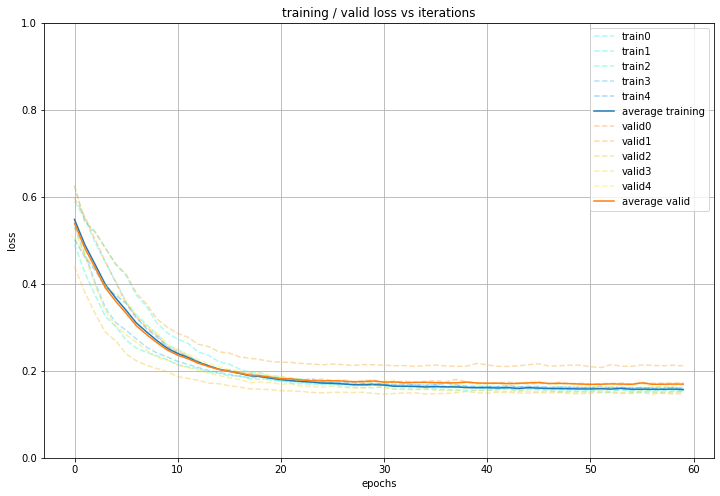

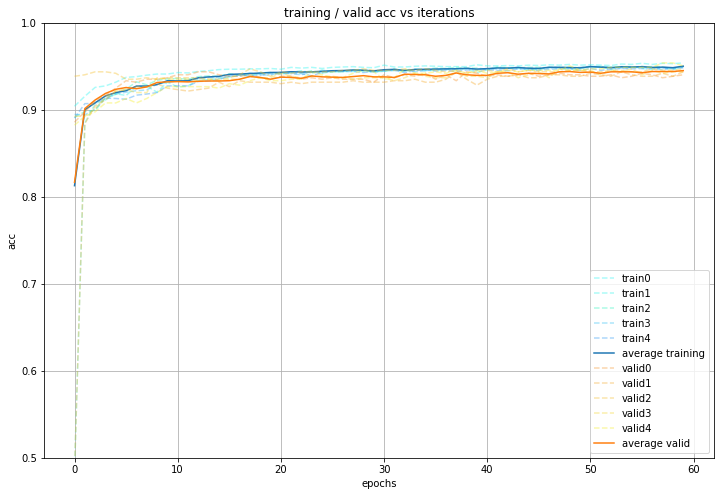

In [47]:
plot_lc_ensemble(training_hist)

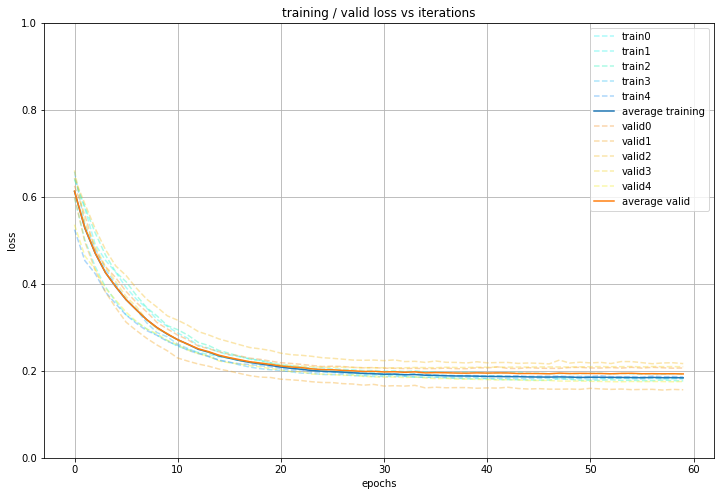

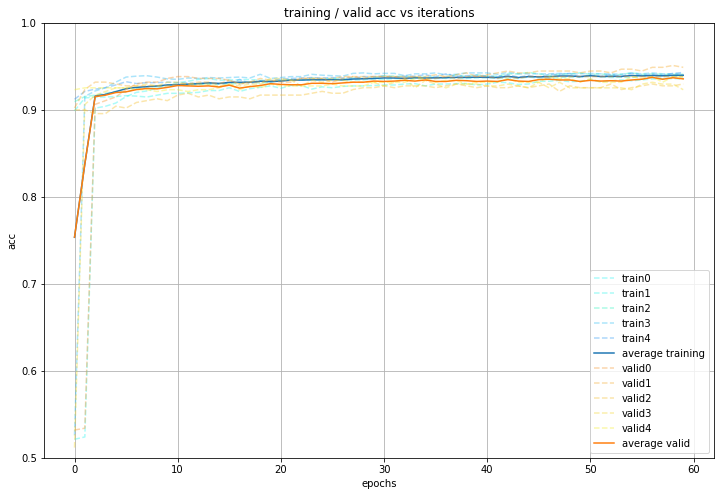

In [143]:
plot_lc_ensemble(training_hist)

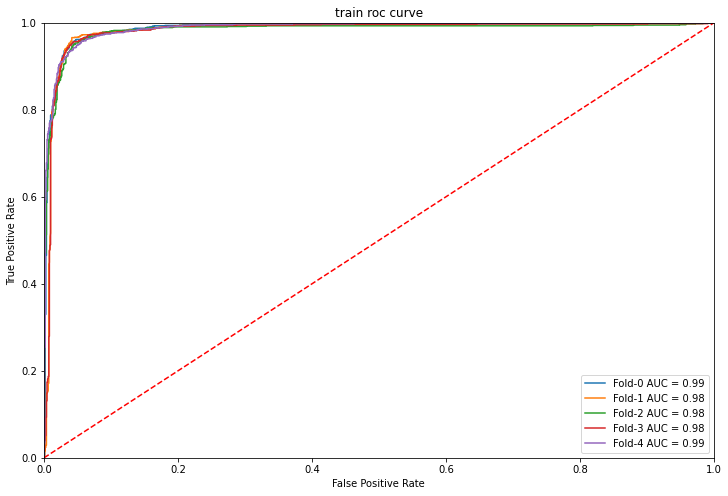

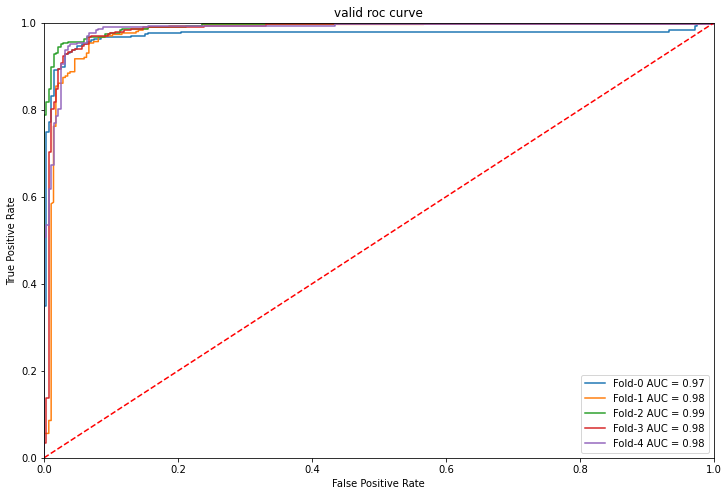

In [30]:
# roc
plot_roc(training_hist, mtype="train")
plot_roc(training_hist, mtype="valid")

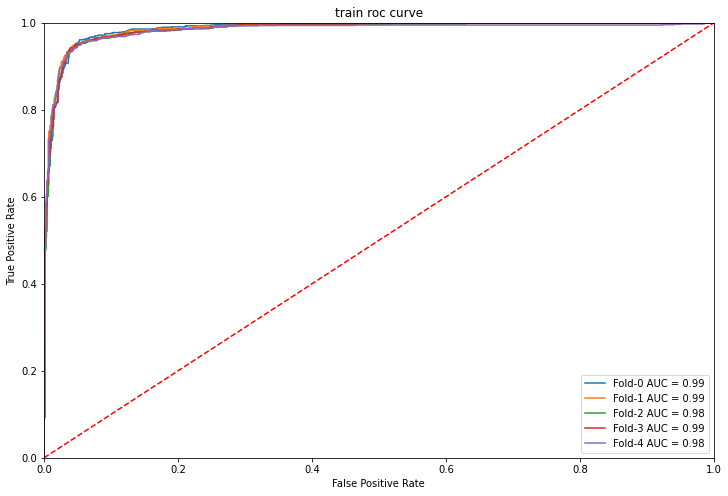

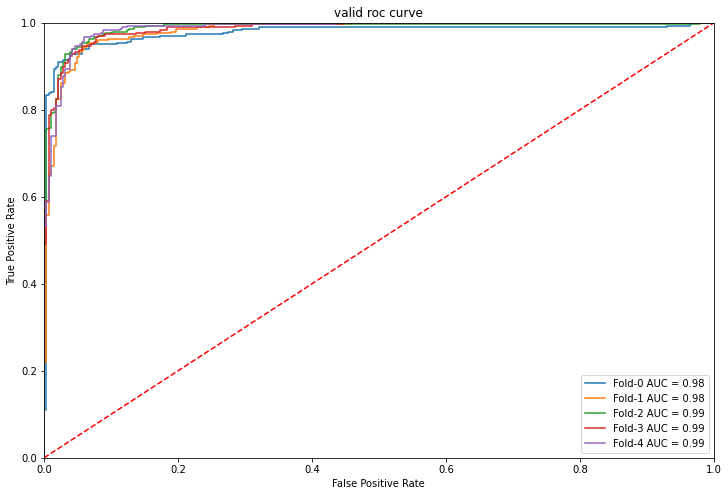

In [48]:
# roc
plot_roc(training_hist, mtype="train")
plot_roc(training_hist, mtype="valid")

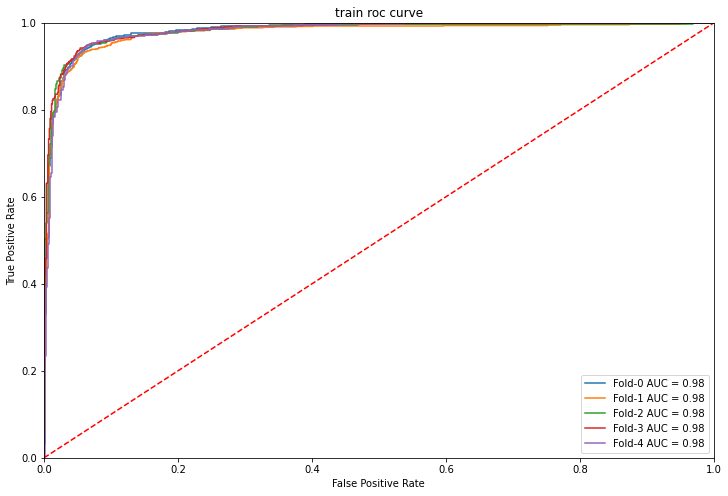

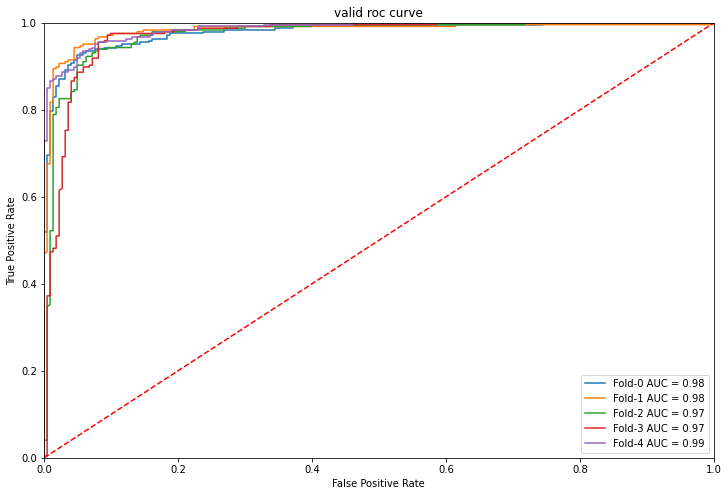

In [144]:
# roc
plot_roc(training_hist, mtype="train")
plot_roc(training_hist, mtype="valid")

## Final model

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [32]:
def check_gpu():
    """
    Check if GPU avaliable.
    """
    print()
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(0))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")
    print()

    return device


device = check_gpu()


There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti



In [33]:
class Data(Dataset):
    # Constructor
    def __init__(self, X, y):
        self.x = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.len = self.y.shape[0]

    # Getter
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # Get Length
    def __len__(self):
        return self.len

In [34]:
dataset = Data(X.values, y.values)

In [35]:
len(dataset)

2935

In [36]:
def train_model_final(
    model, train_loader, optimizer, N_train, device, criterion, scheduler, epochs=10
):
    """
    Training the final model.
    """

    useful_stuff = {
        "training_loss": [],
        "training_acc": [],
        "training_auc": [],
        "training_metric": [],
        "training_fpr": [],
        "training_tpr": [],
        "train_loss": [],
        "train_acc": [],
        "train_auc": [],
        "train_metric": [],
        "train_fpr": [],
        "train_tpr": [],
    }

    for epoch in range(epochs):

        # training
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, train_loader, optimizer, scheduler, device, criterion, training=True
        )

        useful_stuff = calc_metrics(
            N_train,
            train_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="training",
        )

        # evaluate training
        model, correct, training_loss, (TP, FP, TN, FN), y_list, yhat_list = batch_iter(
            model, train_loader, optimizer, scheduler, device, criterion, training=False
        )

        useful_stuff = calc_metrics(
            N_train,
            train_loader,
            correct,
            training_loss,
            (TP, FP, TN, FN),
            y_list,
            yhat_list,
            useful_stuff,
            mtype="train",
        )

    return useful_stuff

In [37]:
# hypterparameter
epochs = 60
batch_size = 32
lr = 2e-4
dropout_rate = 0.1
neuron = 10
print("epochs:", epochs)
print("batch_size:", batch_size)
print("learning rate:", lr)
print("dropout_rate:", dropout_rate)
print("neurons per layer:", neuron)

epochs: 60
batch_size: 32
learning rate: 0.0002
dropout_rate: 0.1
neurons per layer: 10


In [38]:
model = NN(input_dim=7, neuron=neuron, p=dropout_rate)
model.to(device)

N_train = len(dataset)
print("Num of train samples:", N_train)
print("Num of valid samples:", N_test)
print()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr,
)

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=10, factor=0.5, verbose=True
)

tr_loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

useful_stuff = train_model_final(
    model=model,
    train_loader=tr_loader,
    optimizer=optimizer,
    N_train=N_train,
    device=device,
    criterion=criterion,
    scheduler=scheduler,
    epochs=epochs,
)

Num of train samples: 2935
Num of valid samples: 587



In [39]:
def calc_metric_final(useful_stuff):
    """
    calculate metrics.
    args:
        useful_stuff(dict): infomation dict, obtaining acc, loss, auc, ...
        fig_path(str): path to store figures
        data_index(int): what dataset is
    """
    (TP, FP, TN, FN) = useful_stuff["train_metric"][-1]

    acc = (TP + TN) / (TP + FP + TN + FN)
    loss = useful_stuff["train_loss"][-1]

    recall = TP / (TP + FN)  # 召回率是在所有正樣本當中，能夠預測多少正樣本的比例
    specificity = TN / (TN + FP)  # 特異度是在所有負樣本當中，能夠預測多少負樣本的比例
    precision = TP / (TP + FP)  # 準確率為在所有預測為正樣本中，有多少為正樣本
    npv = TN / (TN + FN)  # npv為在所有預測為正樣本中，有多少為正樣本

    f1 = (2 * recall * precision) / (recall + precision)  # F1-score則是兩者的調和平均數
    mcc = (TP * TN - FP * FN) / np.sqrt(((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)))
    auc = useful_stuff["train_auc"][-1]

    print("\n[Training]\n")
    print("total sample:", (TP + FP + TN + FN))
    print("TP: {:.2f}".format(TP))
    print("FP: {:.2f}".format(FP))
    print("TN: {:.2f}".format(TN))
    print("FN: {:.2f}".format(FN))
    print("acc: {:.2f}".format(acc))
    print("loss: {:.2f}".format(loss))
    print("recall: {:.2f}".format(recall))
    print("specificity: {:.2f}".format(specificity))
    print("precision: {:.2f}".format(precision))
    print("npv: {:.2f}".format(npv))
    print("f1: {:.2f}".format(f1))
    print("mcc: {:.2f}".format(mcc))
    print("auc: {:.2f}".format(auc))

In [40]:
calc_metric_final(useful_stuff)


[Training]

total sample: 2935
TP: 1459.00
FP: 69.00
TN: 1350.00
FN: 57.00
acc: 0.96
loss: 0.14
recall: 0.96
specificity: 0.95
precision: 0.95
npv: 0.96
f1: 0.96
mcc: 0.91
auc: 0.99


In [58]:
calc_metric_final(useful_stuff)


[Training]

total sample: 2935
TP: 1449.00
FP: 72.00
TN: 1347.00
FN: 67.00
acc: 0.95
loss: 0.16
recall: 0.96
specificity: 0.95
precision: 0.95
npv: 0.95
f1: 0.95
mcc: 0.91
auc: 0.99


In [184]:
calc_metric_final(useful_stuff)


[Training]

total sample: 2348
TP: 1158.00
FP: 70.00
TN: 1043.00
FN: 77.00
acc: 0.94
loss: 0.18
recall: 0.94
specificity: 0.94
precision: 0.94
npv: 0.93
f1: 0.94
mcc: 0.87
auc: 0.98


In [41]:
# save model
#torch.save(model.state_dict(), "./result/nn_ensemble_wt.pkl")
torch.save(model.state_dict(), "./result/nn_ensemble_wt_com.pkl")

### learning curve

In [42]:
def plot_lc_final(useful_stuff):
    """
    plot learning curve.
    """
    # acc
    plt.plot(useful_stuff["train_acc"], label="train")
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.title("train acc vs epochs")
    plt.grid()
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    plt.show()

    # loss
    plt.plot(useful_stuff["train_loss"], label="train")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("train loss vs epochs")
    plt.grid()
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([0, 1])
    plt.show()

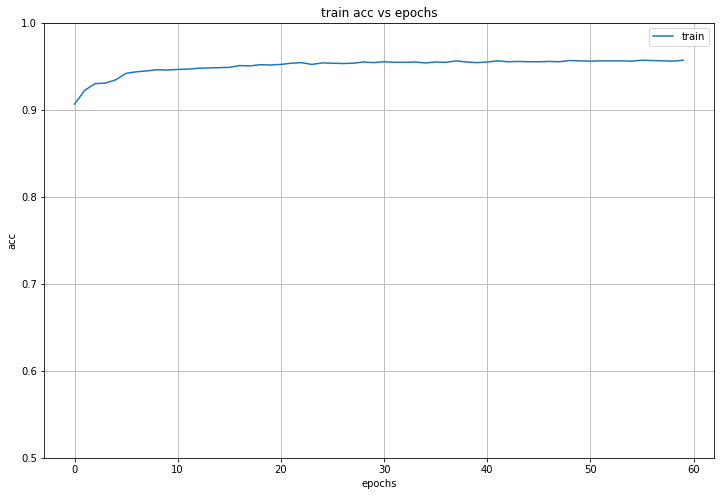

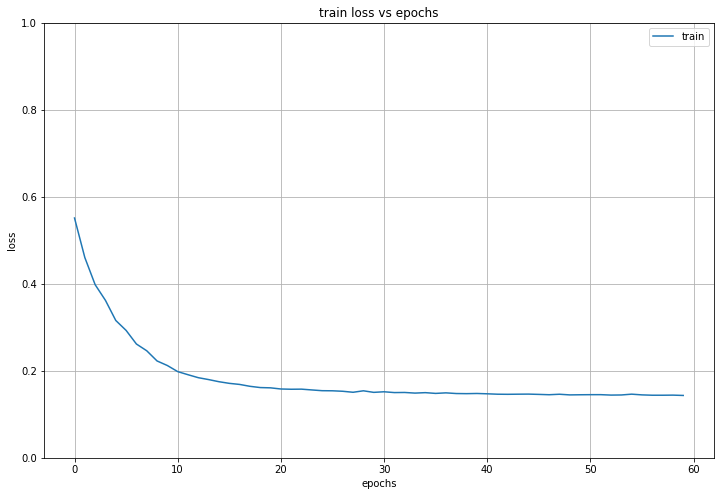

In [43]:
plot_lc_final(useful_stuff)

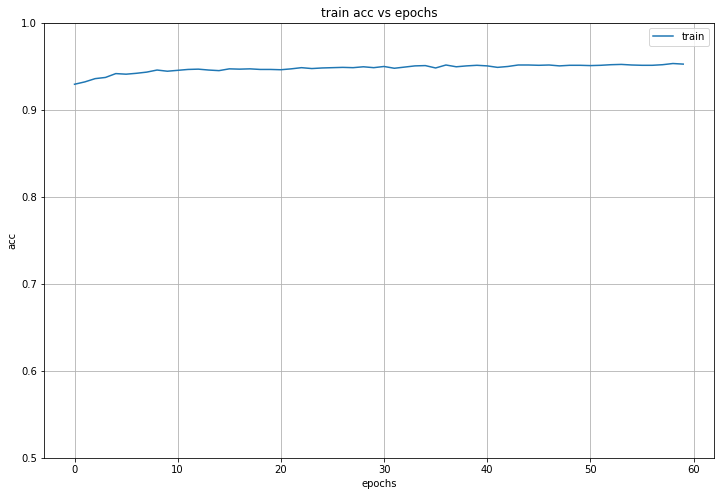

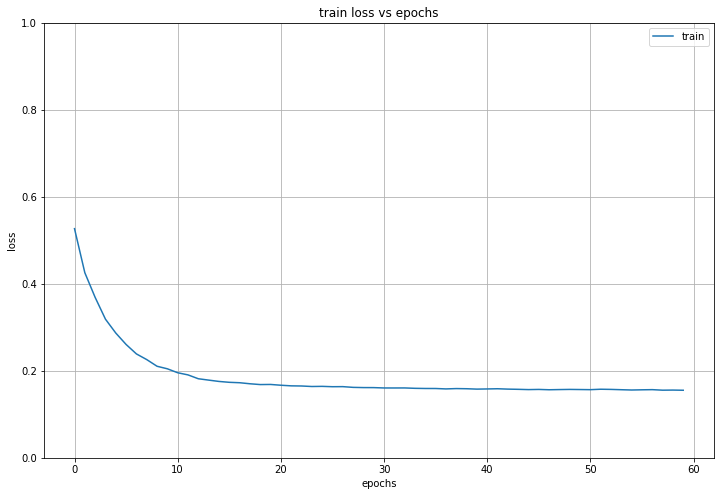

In [61]:
plot_lc_final(useful_stuff)

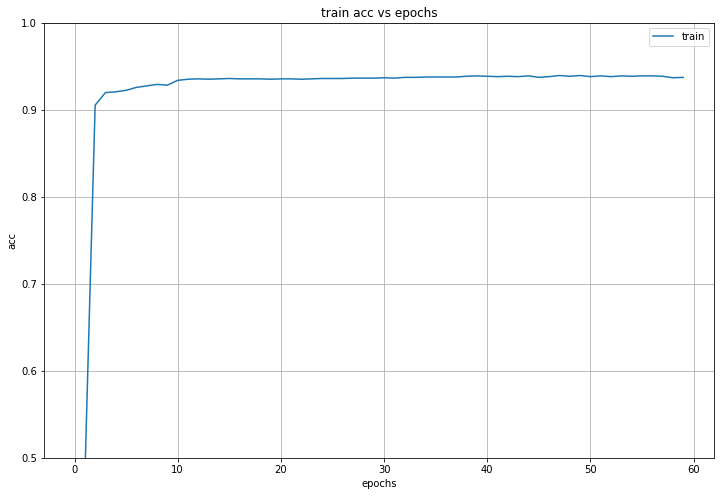

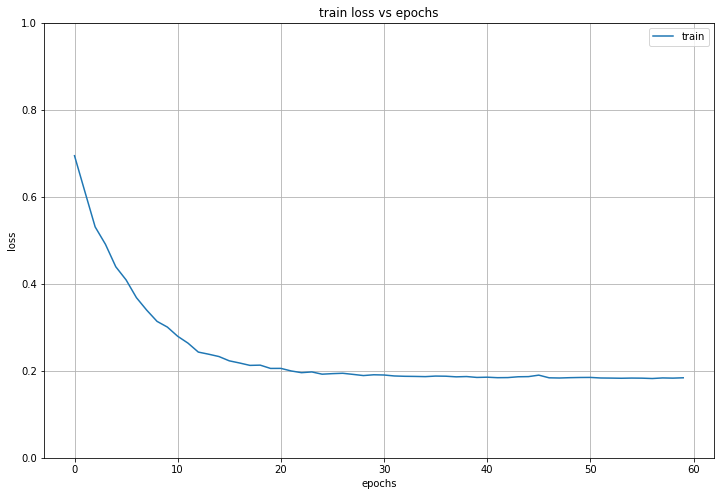

In [187]:
plot_lc_final(useful_stuff)

## Prediction

In [44]:
import pandas as pd
import pickle

In [194]:
# df1 = pd.read_csv(
#     os.path.join(
#         "result", "bert-base-cased_bs_8_epo7", "predict", "submission_softmax.csv"
#     )
# )
# df2 = pd.read_csv(
#     os.path.join(
#         "result", "roberta-base_bs_8_epo10", "predict", "submission_softmax.csv"
#     )
# )
# df3 = pd.read_csv(
#     os.path.join(
#         "result", "xlnet-base-cased_bs_8_epo10", "predict", "submission_softmax.csv"
#     )
# )
# df4 = pd.read_csv(
#     os.path.join(
#         "result",
#         "google_electra-base-discriminator_bs_8_epo10",
#         "predict",
#         "submission_softmax.csv",
#     )
# )
# df5 = pd.read_csv(
#     os.path.join(
#         "result",
#         "microsoft_deberta-base_bs_4_epo9",
#         "predict",
#         "submission_softmax.csv",
#     )
# )

In [45]:
# df1 = pd.read_csv(
#     os.path.join(
#         "result",
#         "bert-base-cased_bs8_lr4e-05_epo10",
#         "predict",
#         "submission_softmax.csv",
#     )
# )
# df2 = pd.read_csv(
#     os.path.join(
#         "result", "roberta-base_bs8_lr4e-05_epo10", "predict", "submission_softmax.csv"
#     )
# )
# df3 = pd.read_csv(
#     os.path.join(
#         "result", "xlnet-base-cased_bs8_lr4e-05_epo10", "predict", "submission_softmax.csv"
#     )
# )
# df4 = pd.read_csv(
#     os.path.join(
#         "result",
#         "google_electra-base-discriminator_bs8_lr4e-05_epo10",
#         "predict",
#         "submission_softmax.csv",
#     )
# )
# df5 = pd.read_csv(
#     os.path.join(
#         "result",
#         "microsoft_deberta-base_bs4_lr2e-05_epo10",
#         "predict",
#         "submission_softmax.csv",
#     )
# )
# df6 = pd.read_csv(
#     os.path.join(
#         "result",
#         "textattack_bert-base-uncased-imdb_bs8_lr4e-05_epo10",
#         "predict",
#         "submission_softmax.csv",
#     )
# )
# df7 = pd.read_csv(
#     os.path.join(
#         "result",
#         "aychang_roberta-base-imdb_bs8_lr4e-05_epo10",
#         "predict",
#         "submission_softmax.csv",
#     )
# )

In [46]:
df1 = pd.read_csv(
    os.path.join(
        "result",
        "bert-base-cased_bs8_lr4e-05_epo2_retrain",
        "predict",
        "submission_softmax.csv",
    )
)
df2 = pd.read_csv(
    os.path.join(
        "result", "roberta-base_bs8_lr4e-05_epo3_retrain", "predict", "submission_softmax.csv"
    )
)
df3 = pd.read_csv(
    os.path.join(
        "result", "xlnet-base-cased_bs8_lr4e-05_epo10", "predict", "submission_softmax.csv"
    )
)
df4 = pd.read_csv(
    os.path.join(
        "result",
        "google_electra-base-discriminator_bs8_lr4e-05_epo2_retrain",
        "predict",
        "submission_softmax.csv",
    )
)
df5 = pd.read_csv(
    os.path.join(
        "result",
        "microsoft_deberta-base_bs4_lr2e-05_epo1_retrain",
        "predict",
        "submission_softmax.csv",
    )
)
df6 = pd.read_csv(
    os.path.join(
        "result",
        "textattack_bert-base-uncased-imdb_bs8_lr4e-05_epo1_retrain",
        "predict",
        "submission_softmax.csv",
    )
)
df7 = pd.read_csv(
    os.path.join(
        "result",
        "aychang_roberta-base-imdb_bs8_lr4e-05_epo2_retrain",
        "predict",
        "submission_softmax.csv",
    )
)

FileNotFoundError: [Errno 2] No such file or directory: 'result/bert-base-cased_bs8_lr4e-05_epo2_retrain/predict/submission_softmax.csv'

In [66]:
test = pd.DataFrame(
    {
        "model_1": df1["sentiment"],
        "model_2": df2["sentiment"],
        "model_3": df3["sentiment"],
        "model_4": df4["sentiment"],
        "model_5": df5["sentiment"],
        "model_6": df6["sentiment"],
        "model_7": df7["sentiment"],
    }
)
test

,model_1,model_2,model_3,model_4,model_5,model_6,model_7
0,0.954694,0.007148,0.004473,0.020443,0.004393,0.899640,0.005153
1,0.995194,0.977064,0.989850,0.997421,0.998992,0.990914,0.991151
2,0.002859,0.007190,0.005616,0.007235,0.004115,0.002578,0.005026
3,0.002950,0.007046,0.005281,0.006569,0.002313,0.001895,0.005027
4,0.992811,0.838881,0.016245,0.970414,0.997132,0.009155,0.005033
...,...,...,...,...,...,...,...
29336,0.006190,0.007643,0.030410,0.015181,0.003474,0.007926,0.005857
29337,0.995844,0.977211,0.988617,0.998233,0.999251,0.992691,0.991152
29338,0.003448,0.007202,0.005533,0.007934,0.004628,0.001960,0.005032
29339,0.003205,0.008288,0.003503,0.007445,0.002699,0.011768,0.005027


In [67]:
class Data(Dataset):
    # Constructor
    def __init__(self, X):
        self.x = torch.from_numpy(X).float()
        self.len = self.x.shape[0]

    # Getter
    def __getitem__(self, index):
        return self.x[index]

    # Get Length
    def __len__(self):
        return self.len

In [68]:
dataset = Data(test.values)

In [69]:
len(dataset)

29341

In [70]:
test_loader = DataLoader(dataset, shuffle=False, batch_size=32)

In [71]:
model.eval()
prediction = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        z = model(x)
        _, yhat = torch.max(z.data, 1)
        prediction.extend(yhat.cpu().tolist())

In [72]:
len(prediction)

29341

### submission

In [73]:
with open("./data/test_rm_br.pkl", "rb") as f:
    test = pickle.load(f)

In [74]:
test

,ID,review
0,22622,Robert Lansing plays a scientist experimenting...
1,10162,"Well I've enjoy this movie, even though someti..."
2,17468,First things first - though I believe Joel Sch...
3,42579,I watched this movie on the grounds that Amber...
4,701,A certain sexiness underlines even the dullest...
...,...,...
29336,30370,It is difficult to rate a writer/director's fi...
29337,18654,"After watching this movie once, it quickly bec..."
29338,47985,"Even though i sat and watched the whole thing,..."
29339,9866,Warning Spoilers following. Superb recreation ...


In [75]:
df = pd.DataFrame({"ID": test.ID, "sentiment": prediction})
df

,ID,sentiment
0,22622,0
1,10162,1
2,17468,0
3,42579,0
4,701,0
...,...,...
29336,30370,0
29337,18654,1
29338,47985,0
29339,9866,0


In [76]:
df.to_csv("./result/nn_ensemble_wt.csv", index=False, encoding="utf-8")